In [84]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import matplotlib 
from PIL import Image
import math
from random import random
from random import seed
from random import randint
import time
from numba import jit
from mpl_toolkits.mplot3d import Axes3D


from matplotlib.colors import LinearSegmentedColormap
import functools
import itertools as IT
import scipy.ndimage as ndimage
import matplotlib.cm as cm

In [104]:
# comoving but the strings stay put (ideal for radiation or matter)

def cartesian_product_broadcasted(*arrays):
    """
    http://stackoverflow.com/a/11146645/190597 (senderle)
    """
    broadcastable = np.ix_(*arrays)
    broadcasted = np.broadcast_arrays(*broadcastable)
    dtype = np.result_type(*arrays)
    rows, cols = functools.reduce(np.multiply, broadcasted[0].shape), len(broadcasted)
    out = np.empty(rows * cols, dtype=dtype)
    start, end = 0, rows
    for a in broadcasted:
        out[start:end] = a.reshape(-1)
        start, end = end, end + rows
    return out.reshape(cols, rows).T

@jit(nopython = True)
def Laplacian(A,deltax,deltat):

    h = len(A)
    #CFL condition delta x => sqrt(D) delta t, where D is the number of dimensions            
    P = np.zeros((h,h,h))
    result = np.zeros((h,h,h))

  
    for i in range(0, h):
        for j in range(0,h):
            for k in range(0,h):
                P[i,j,k] = (A[(i-1)%h,(j-1)%h,(k-1)%h] + 3*A[(i-1)%h,j,(k-1)%h] + A[(i-1)%h,(j+1)%h,(k-1)%h] \
                + 3*A[(i-1)%h,(j-1)%h,k] + 14*A[(i-1)%h,j,k] + 3*A[(i-1)%h,(j+1)%h,k] \
                + A[(i-1)%h,(j-1)%h,(k+1)%h] + 3*A[(i-1)%h,j,(k+1)%h] + A[(i-1)%h,(j+1)%h,(k+1)%h] \
                + 3*A[i,(j-1)%h,(k-1)%h] + 14*A[i,j,(k-1)%h] + 3*A[i,(j+1)%h,(k-1)%h] \
                + 14*A[i,(j-1)%h,k] - 128*A[i,j,k] + 14*A[i,(j+1)%h,k] \
                + 3*A[i,(j-1)%h,(k+1)%h] + 14*A[i,j,(k+1)%h] + 3*A[i,(j+1)%h,(k+1)%h] \
                + A[(i+1)%h,(j-1)%h,(k-1)%h] + 3*A[(i+1)%h,j,(k-1)%h] + A[(i+1)%h,(j+1)%h,(k-1)%h] \
                + 3*A[(i+1)%h,(j-1)%h,k] + 14*A[(i+1)%h,j,k] + 3*A[(i+1)%h,(j+1)%h,k] \
                + A[(i+1)%h,(j-1)%h,(k+1)%h] + 3*A[(i+1)%h,j,(k+1)%h] + A[(i+1)%h,(j+1)%h,(k+1)%h])/(30*pow(deltax,2))
    return P 



def update(N,A1,A2,vel1,vel2,omega,eta,deltax,deltat,a,time):
    H_0 = 2.18e-18
    a = np.sqrt(2*H_0)*np.sqrt(time)
    #a = H_0 ** (2/3) * time ** (2/3)
    beta = 0
    alpha = 3
    era = 1 #radiation
    #era = 2 #matter

    lam = 2*pow(math.pi,2)/pow(omega,2)
    

    
    F1 = Laplacian(A1,deltax,deltat) - a**beta * lam*A1*(pow(A1,2)+pow(A2,2)-pow(eta,2))-alpha*era*vel1
    F2 = Laplacian(A2,deltax,deltat) - a**beta * lam*A2*(pow(A1,2)+pow(A2,2)-pow(eta,2))-alpha*era*vel2
    
    time = time + deltat
    
    a1 = np.sqrt(2*H_0)*np.sqrt(time)
    

    
    A1 = A1 + deltat*(vel1 + 0.5*deltat*F1) 
    A2 = A2 + deltat*(vel2 + 0.5*deltat*F2) 

    
    vel1 = vel1 + deltat/2*(F1 + Laplacian(A1,deltax,deltat) - a1**beta *lam*A1*(pow(A1,2)+pow(A2,2)-pow(eta,2)) -alpha*era*vel1) 
    vel2 = vel2 + deltat/2*(F2 + Laplacian(A2,deltax,deltat) - a1**beta *lam*A2*(pow(A1,2)+pow(A2,2)-pow(eta,2)) -alpha*era*vel2)
    
    
    return A1,A2,vel1,vel2,a,time
    
#change the values accordlingly    
def wolff(N,t0,t,A1,A2,vel,omega,eta,deltax,deltat):

    time = t0
    a = 0

    vel1 = vel
    vel2 = vel
    

    fig = plt.figure(figsize=(50,50))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_axis_off()
    size = N
    x, y, z = cartesian_product_broadcasted(*[np.arange(size, dtype='int16')]*3).T
    mask = ((x == 0) | (x == size-1) 
            | (y == 0) | (y == size-1) 
            | (z == 0) | (z == size-1))
    x = x[mask]
    y = y[mask]
    z = z[mask]
    color_map = plt.cm.get_cmap('Greys')
    reversed_color_map = color_map.reversed()



    for i in np.arange(int(t/deltat)):
        time = round(time,1)
        
        if time % 1 == 0:
            
            mod = np.sqrt(pow(A1,2)+pow(A2,2))
            mod = mod.ravel()[mask]
            #angle = np.arctan2(A2,A1)
            #angle = angle.ravel()[mask]
            
            ax.scatter(x, y, z, c=mod, cmap=reversed_color_map,vmin = 0, vmax = eta)
            plt.savefig('958/'+str(int(time)).zfill(3)+'.png')
    
            
            
            #ax.scatter(x, y, z, c=mod, cmap=plt.get_cmap('rainbow_alpha'),vmin = 0, vmax = eta)
            #plt.savefig('961/'+str(int(time)).zfill(3)+'.png')
            
            #plt.imsave('958/'+str(int(time)).zfill(3)+'.png',np.sqrt(pow(A1,2)+pow(A2,2)),vmin = 0, vmax = eta,cmap = 'Greys')
            #plt.imsave('961/'+str(int(time)).zfill(3)+'.png',np.arctan2(A2,A1),vmin = -1*math.pi, vmax = math.pi,cmap = 'twilight')

            
        A1,A2,vel1,vel2,a,time = update(N,A1,A2,vel1,vel2,omega,eta,deltax,deltat,a,time)


    return A1,A2

In [ ]:
start = time.time()


n = 8
deltax = 1
deltat = 0.1
eta = 1
N = pow(2,n)
t = 0.5*N*deltax/deltat # light crossing time
t0 = 0.1
t2 = t/2 # half time
t5 = t/5
t10 = t/10 # 1/10 of the ligth crossing time

vel = np.zeros((N,N,N))
mu, sigma = 0, 0.1 # mean and standard deviation
omega = 5

print(t)



A1 = np.random.normal(mu, sigma, size=(N,N,N))
A2 = np.random.normal(mu,sigma,size=(N,N,N))

A1,A2 = wolff(N,t0,t5,A1,A2,vel,omega,eta,deltax,deltat)

end = time.time()
print(end - start)

1280.0


In [97]:

# get colormap
ncolors = 256
color_array = plt.get_cmap('Greys')(range(ncolors))

# change alpha values
color_array[:,-1] = np.linspace(1.0,0.0,ncolors)

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

<ipython-input-97-3773a2080020>:12: UserWarning: Trying to register the cmap 'rainbow_alpha' which already exists.
  plt.register_cmap(cmap=map_object)


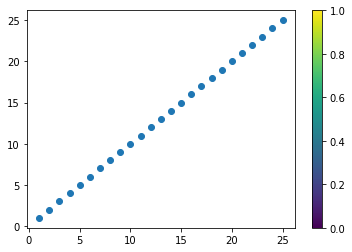

In [80]:
x = np.linspace(1,25,25)
y = x

plt.scatter(x, y, cmap=reversed_color_map, vmin = 1,vmax = 25)

colorbar = plt.colorbar()

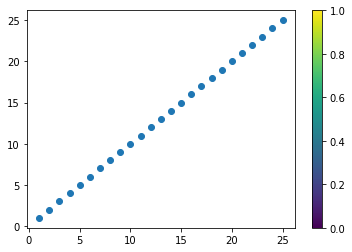

In [81]:
plt.scatter(x, y, cmap=plt.get_cmap('rainbow_alpha'), vmin = 1,vmax = 25)

colorbar = plt.colorbar()

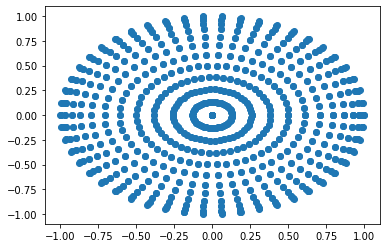

In [91]:
color_map = plt.cm.get_cmap('Greys')
plt.scatter(x, y, cmap=color_map, vmin=0,vmax=25)